This notebook replicates the brain-related analyses. Note: the fMRI data can be downloaded into the data folder from here: https://dataspace.princeton.edu/jspui/handle/88435/dsp01nz8062179

## Import libraries

In [1]:
import numpy as np
from os.path import join as opj
from fastdtw import fastdtw
from nilearn import datasets, plotting, surface
from nilearn.image import concat_imgs, load_img, new_img_like
from scipy.spatial.distance import cdist, correlation
from scipy.stats import ttest_1samp as ttest

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set paths & parameters

In [2]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'

sns.set_context('talk')
mpl.rcParams['pdf.fonttype'] = 42
brain_cmap = 'cold_hot'
corrmat_cmap = plt.cm.bone_r

## Define functions

In [3]:
def r2z(r):
    # compute the Fisher z-transformation
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

## Load in permutations

In [5]:
video_perms = [load_img(opj(datadir, f'searchlight_movie/perm{perm}.nii')) for perm in range(100)]
video_perms = concat_imgs(video_perms).get_data().astype(np.float64)

recall_perms = [load_img(opj(datadir, f'searchlight_recall/perm{perm}.nii')) for perm in range(1, 101)]
recall_perms = concat_imgs(recall_perms).get_data().astype(np.float64)

## Load in real data

In [6]:
ref_img = load_img(opj(datadir, 'searchlight_movie/ref.nii.gz'))
                   
subs = range(1, 18)
vid_imgs = []
rec_imgs = []
for sub in subs:
    sub_vdata = np.load(opj(datadir, f'searchlight_movie/s{sub}.npy'), allow_pickle=True)
    sub_rdata = np.load(opj(datadir, f'searchlight_recall/s{sub}.npy'), allow_pickle=True)
    vid_img = new_img_like(ref_img, sub_vdata.astype(np.float64))
    rec_img = new_img_like(ref_img, sub_rdata.astype(np.float64))
    vid_imgs.append(vid_img)
    rec_imgs.append(rec_img)
    
vid_imgs = concat_imgs(vid_imgs)
rec_imgs = concat_imgs(rec_imgs)

## Get stats for real data

In [7]:
video_data = vid_imgs.get_data().astype(np.float64)
video_statmap = ttest(np.moveaxis(r2z(video_data), -1, 0), 0).statistic
video_img = new_img_like(ref_img, video_statmap.astype(np.float64))


recall_data = rec_imgs.get_data().astype(np.float64)
recall_statmap = ttest(np.moveaxis(r2z(recall_data), -1, 0), 0).statistic
recall_img = new_img_like(ref_img, recall_statmap.astype(np.float64))

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Do permutation correction

In [30]:
real_video = video_img.get_data().astype(np.float64)
real_recall = recall_img.get_data().astype(np.float64)

zval_video = (real_video - np.nanmean(video_perms, axis=3)) / np.nanstd(video_perms, axis=3)
pval_video = (real_video[:, :, :, np.newaxis] < video_perms).sum(axis=3) / 100
zval_recall = (real_recall - np.nanmean(recall_perms, axis=3)) / np.nanstd(recall_perms, axis=3)
pval_recall = (real_recall[:, :, :, np.newaxis] < recall_perms).sum(axis=3) / 100

zval_video = np.nan_to_num(zval_video)
pval_video = np.nan_to_num(pval_video)
zval_recall = np.nan_to_num(zval_recall)
pval_recall = np.nan_to_num(pval_recall)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


## Threshold

In [32]:
# direct variation with video/recall structure
zval_video[(pval_video > .025) & (zval_video > 0)] = 0
zval_recall[(pval_recall > .025) & (zval_recall > 0)] = 0

# inverse variation with video/recall structure
zval_video[(pval_video < .975) & (zval_video < 0)] = 0
zval_recall[(pval_recall < .975) & (zval_recall < 0)] = 0

zmap_video = new_img_like(ref_img, zval_video.astype(np.float64))
zmap_recall = new_img_like(ref_img, zval_recall.astype(np.float64))

In [10]:
# zval_video[pval_video > .05] = 0
# zval_video[zval_video < 0] = 0

# zval_recall[pval_recall > .05] = 0
# zval_recall[zval_recall < 0] = 0

# zmap_video = new_img_like(ref_img, zval_video.astype(np.float64))
# zmap_recall = new_img_like(ref_img, zval_recall.astype(np.float64))

## Plot video

In [33]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
vid_texture_pr = surface.vol_to_surf(zmap_video, fsaverage.pial_right)
vid_texture_pl = surface.vol_to_surf(zmap_video, fsaverage.pial_left)

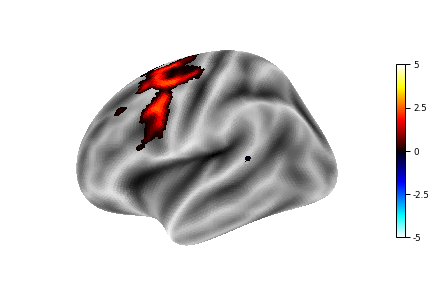

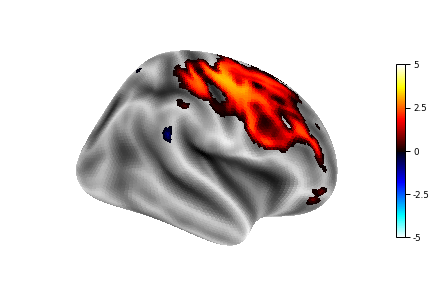

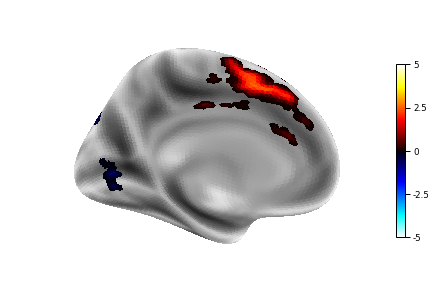

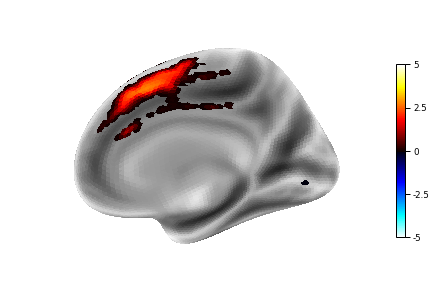

In [36]:
plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', view='lateral', 
                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', view='lateral', 
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', view='medial', 
                            bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', view='medial', 
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

In [35]:
# fig = plt.figure(figsize=(12,10))
# axarr = []
# for a in range(1, 5):
#     ax = fig.add_subplot(f'22{a}', projection='3d')
#     axarr.append(ax)

# plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[0])
# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[1])
# plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[2])
# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[3])
# for ax in axarr:
#     ax.dist = 6

# cbar_mappable = mpl.cm.ScalarMappable(cmap='cold_hot', norm=mpl.colors.Normalize(vmin=-5, vmax=5))
# cbar_axes, cbar_kws = mpl.colorbar.make_axes([axarr[1], axarr[3]], 
#                                              location='right', fraction=.1, shrink=.9, pad=.0, panchor=(1.2, .5))

# fig.colorbar(cbar_mappable, cax=cbar_axes, ticks=np.linspace(-5, 5, 5))
# # plt.tight_layout()
# plt.show()

## Plot recall

In [38]:
rec_texture_pr = surface.vol_to_surf(zmap_recall, fsaverage.pial_right)
rec_texture_pl = surface.vol_to_surf(zmap_recall, fsaverage.pial_left)

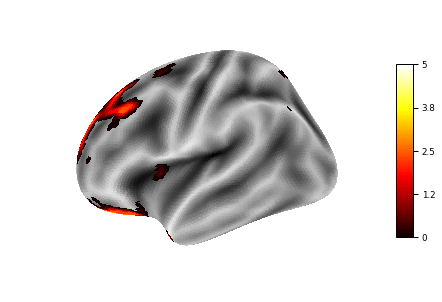

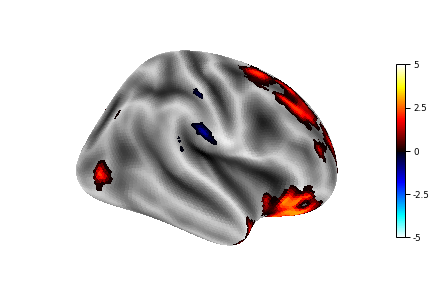

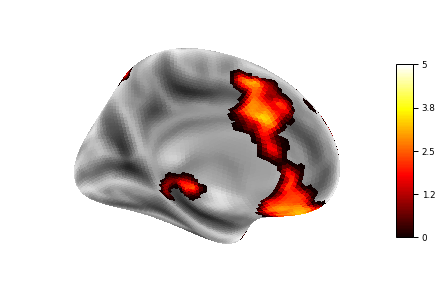

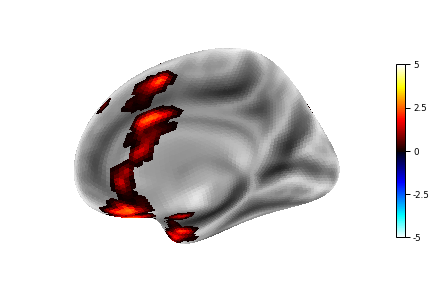

In [39]:
plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', view='lateral', 
                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', view='lateral', 
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', view='medial', 
                            bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', view='medial', 
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

In [37]:
# fig = plt.figure(figsize=(12,10))
# axarr = []
# for a in range(1, 5):
#     ax = fig.add_subplot(f'22{a}', projection='3d')
#     axarr.append(ax)

# plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[0])
# plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[1])
# plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[2])
# plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=3, colorbar=False, axes=axarr[3])
# for ax in axarr:
#     ax.dist = 6

# cbar_mappable = mpl.cm.ScalarMappable(cmap='cold_hot', norm=mpl.colors.Normalize(vmin=-5, vmax=5))
# cbar_axes, cbar_kws = mpl.colorbar.make_axes([axarr[1], axarr[3]], 
#                                              location='right', fraction=.1, shrink=.9, pad=.0, panchor=(1.2, .5))

# fig.colorbar(cbar_mappable, cax=cbar_axes, ticks=np.linspace(-5, 5, 5))
# # plt.tight_layout()
# plt.show()

## Load video and example recall models

In [45]:
video, recalls = np.load('../../../data/processed/models_t100_v50_r10.npy', allow_pickle=True)
recall = recalls[16]

## Warp recall model to TR timeseries

In [46]:
dist, path = fastdtw(video, recall, dist=correlation)
rec_path = [i[1] for i in path]
rec_dtw = recall[rec_path]

## Construct correlation matrices

In [47]:
v_v_corrmat = np.corrcoef(video)
v_r_corrmat = 1 - cdist(video, recall, 'correlation')
v_r_corrmat_dtw = 1 - cdist(video, rec_dtw, 'correlation')

## Plot figure

In [40]:
# # corrmats_locs = [(0, 1), (0, 4), (0, 6)]
# # brains_locs = [(2, 0), (2, 2), (4, 0), (2, 4), 
# #                (2, 6), (4, 2), (4, 4), (4, 6)]
# # plt.figure(figsize=(12, 8))
# # axarr = [plt.subplot2grid((6, 8), loc, rowspan=2, colspan=2) for loc in corrmats_locs]
# # axarr += [plt.subplot2grid((6, 8), loc, rowspan=2, colspan=2, projection='3d') for loc in brains_locs]

# corrmats_locs = [(0, 1), (0, 4), (0, 6)]
# brains_locs = [(2, 0), (2, 2), (4, 0), (2, 4), 
#                (2, 6), (4, 2), (4, 4), (4, 6)]
# plt.figure(figsize=(12, 8))
# axarr = [plt.subplot2grid((11, 16), loc, rowspan=3, colspan=3) for loc in corrmats_locs]
# axarr += [plt.subplot2grid((11, 16), loc, rowspan=4, colspan=4, projection='3d') for loc in brains_locs]

# # Video correlation matrix
# sns.heatmap(v_v_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[0])
# axarr[0].set_xlabel('Viewing time (TR)')
# axarr[0].set_ylabel('Viewing time (TR)')
# axarr[0].set_title('Video correlation matrix')
# for _, spine in axarr[0].spines.items():
#     spine.set_visible(True)
# axarr[0].collections[0].remove()
# axarr[0].imshow(v_v_corrmat, aspect='auto', cmap=corrmat_cmap)

# # P17 video-recall correlation matrix
# sns.heatmap(v_r_corrmat, xticklabels=100, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[1])
# axarr[1].set_xlabel('Recall time (window)')
# axarr[1].set_ylabel('Viewing time (TR)')
# axarr[1].set_title('P17 video-recall\ncorrelation matrix')
# for _, spine in axarr[1].spines.items():
#     spine.set_visible(True)
# axarr[1].collections[0].remove()
# axarr[1].imshow(v_r_corrmat, aspect='auto', cmap=corrmat_cmap) #aspect=v_r_corrmat.shape[1] / v_r_corrmat.shape[0], cmap=corrmat_cmap)

# for vid_ix, rec_ix in path:
#     pt = patches.Rectangle((rec_ix, vid_ix), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
#     axarr[1].add_patch(pt)
    
# # P17 warped video-recall correlation matrix
# sns.heatmap(v_r_corrmat_dtw, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[2])
# axarr[2].set_xlabel('Recall time (TR)')
# axarr[2].set_ylabel('Viewing time (TR)')
# axarr[2].set_title('Warped P17 video-recall\ncorrelation matrix')
# for _, spine in axarr[2].spines.items():
#     spine.set_visible(True)
# axarr[2].collections[0].remove()
# axarr[2].imshow(v_r_corrmat_dtw, aspect='auto', cmap=corrmat_cmap) #aspect='equal', cmap=corrmat_cmap)

# for i in range(1976):
#     pt = patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
#     axarr[2].add_patch(pt)


# # video searchlight brainmaps
# plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[3])
# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[4])
# plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[5])
# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[6])

# # recall searchlight brainmaps
# plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[7])
# plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='lateral', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[8])
# plotting.plot_surf_stat_map(fsaverage.infl_left, rec_texture_pl, hemi='left', bg_map=fsaverage.sulc_left, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[9])
# plotting.plot_surf_stat_map(fsaverage.infl_right, rec_texture_pr, hemi='right', bg_map=fsaverage.sulc_right, 
#                             view='medial', cmap='cold_hot', threshold=.01, vmax=5, colorbar=False, axes=axarr[10])

# # axarr[7].dist = 5
# plt.tight_layout()
# # axarr[6].dist = 5
# # axarr[7].dist = 6
# # axarr[8].dist = 7

# plt.show()

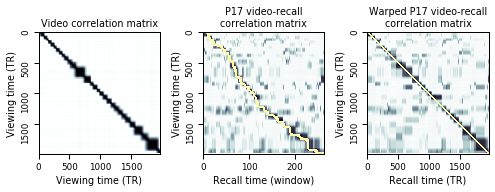

In [58]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(7, 3)

# Video correlation matrix
sns.heatmap(v_v_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[0])
axarr[0].set_xlabel('Viewing time (TR)')
axarr[0].set_ylabel('Viewing time (TR)')
axarr[0].set_title('Video correlation matrix')
for _, spine in axarr[0].spines.items():
    spine.set_visible(True)
axarr[0].collections[0].remove()
axarr[0].imshow(v_v_corrmat, aspect='equal', cmap=corrmat_cmap)

# P17 video-recall correlation matrix
sns.heatmap(v_r_corrmat, xticklabels=100, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[1])
axarr[1].set_xlabel('Recall time (window)')
axarr[1].set_ylabel('Viewing time (TR)')
axarr[1].set_title('P17 video-recall\ncorrelation matrix')
for _, spine in axarr[1].spines.items():
    spine.set_visible(True)
axarr[1].collections[0].remove()
axarr[1].imshow(v_r_corrmat, aspect=v_r_corrmat.shape[1] / v_r_corrmat.shape[0], cmap=corrmat_cmap)

for vid_ix, rec_ix in path:
    pt = patches.Rectangle((rec_ix, vid_ix), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    axarr[1].add_patch(pt)
    
# P17 warped video-recall correlation matrix
sns.heatmap(v_r_corrmat_dtw, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=axarr[2])
axarr[2].set_xlabel('Recall time (TR)')
axarr[2].set_ylabel('Viewing time (TR)')
axarr[2].set_title('Warped P17 video-recall\ncorrelation matrix')
for _, spine in axarr[2].spines.items():
    spine.set_visible(True)
axarr[2].collections[0].remove()
axarr[2].imshow(v_r_corrmat_dtw, aspect='equal', cmap=corrmat_cmap)

for i in range(1976):
    pt = patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    axarr[2].add_patch(pt)

plt.tight_layout()
# plt.savefig(opj(figdir, 'brain_corrmats.pdf'), dpi=1000)
plt.show()